On commence par un modèle Naif: On prévoit à J+7(8) la valeur moyenne de la journée actuelle.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations = list(stations_debit["Code station"])

In [4]:
mesures_train_X = pd.read_csv("../Data/Base/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

Pas besoin d'entrainer de modèle on apprend rien, on fait juste une moyenne et on extrapole.

In [5]:
%run Modele_Naif_fcts.py
%run Eval_fcts.py
%run Standardize_fcts.py

## Score de Validation croisée.

In [5]:
cv_scores_RMSE_standard = pd.DataFrame({"Code station": liste_stations})
cv_scores_MAE_standard = pd.DataFrame({"Code station": liste_stations})
cv_scores_R2_standard = pd.DataFrame({"Code station": liste_stations})
    
cv_scores_RMSE = pd.DataFrame({"Code station": liste_stations})
cv_scores_MAE = pd.DataFrame({"Code station": liste_stations})
cv_scores_R2 = pd.DataFrame({"Code station": liste_stations})

for curr_split in tqdm(range(9)):
    
    curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
    curr_train_X_mean = curr_train_X[liste_stations].mean()
    curr_train_X_std = curr_train_X[liste_stations].std()
    curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
    curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
    liste_dates = curr_test_Y["Date"]
    predictions_Y = fct_Modele_Naif(curr_test_X, liste_dates, liste_stations)

    # Scores
    curr_scores_RMSE = fct_RMSE(curr_test_Y, predictions_Y, liste_stations)
    cv_scores_RMSE["Split_" + str(curr_split)] = curr_scores_RMSE["RMSE"]
    curr_scores_MAE = fct_MAE(curr_test_Y, predictions_Y, liste_stations)
    cv_scores_MAE["Split_" + str(curr_split)] = curr_scores_MAE["MAE"]
    curr_scores_R2 = fct_R2(curr_test_Y, predictions_Y, liste_stations)
    cv_scores_R2["Split_" + str(curr_split)] = curr_scores_R2["R2"]
    # Scores standards
    predictions_Y_standard = fct_Standardize(predictions_Y,
                                             curr_train_X_mean, curr_train_X_std,
                                             liste_stations)
    predictions_Y_standard["Date"] = predictions_Y["Date"]
    curr_test_Y_standard = fct_Standardize(curr_test_Y,
                                             curr_train_X_mean, curr_train_X_std,
                                             liste_stations)
    curr_test_Y_standard["Date"] = curr_test_Y["Date"]
    curr_RMSE = fct_RMSE(curr_test_Y_standard, predictions_Y_standard, liste_stations)
    cv_scores_RMSE_standard["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
    curr_MAE = fct_MAE(curr_test_Y_standard, predictions_Y_standard, liste_stations)
    cv_scores_MAE_standard["Split_" + str(curr_split)] = curr_MAE["MAE"]
    curr_R2 = fct_R2(curr_test_Y_standard, predictions_Y_standard, liste_stations)
    cv_scores_R2_standard["Split_" + str(curr_split)] = curr_R2["R2"]

100%|██████████| 9/9 [00:02<00:00,  3.01it/s]


In [6]:
cv_moyen_RMSE_standard = []
cv_moyen_MAE_standard = []
cv_moyen_R2_standard = []
    
cv_moyen_RMSE = []
cv_moyen_MAE = []
cv_moyen_R2 = []

for code in liste_stations:
    score_RMSE = np.mean(cv_scores_RMSE_standard[cv_scores_RMSE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_RMSE_standard.append(score_RMSE)
    score_MAE = np.mean(cv_scores_MAE_standard[cv_scores_MAE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_MAE_standard.append(score_MAE)
    score_R2 = np.mean(cv_scores_R2_standard[cv_scores_R2_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_R2_standard.append(score_R2)
    score_RMSE = np.mean(cv_scores_RMSE[cv_scores_RMSE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_RMSE.append(score_RMSE)
    score_MAE = np.mean(cv_scores_MAE[cv_scores_MAE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_MAE.append(score_MAE)
    score_R2 = np.mean(cv_scores_R2[cv_scores_R2["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_R2.append(score_R2)

cv_scores_RMSE_standard["Moyenne"] = cv_moyen_RMSE_standard
cv_scores_RMSE_standard.to_csv("../Data/Naif/CV_RMSE_standard.csv",
                          index=False)
cv_scores_MAE_standard["Moyenne"] = cv_moyen_MAE_standard
cv_scores_MAE_standard.to_csv("../Data/Naif/CV_MAE_standard.csv",
                          index=False)
cv_scores_R2_standard["Moyenne"] = cv_moyen_R2_standard
cv_scores_R2_standard.to_csv("../Data/Naif/CV_R2_standard.csv",
                          index=False)
cv_scores_RMSE["Moyenne"] = cv_moyen_RMSE
cv_scores_RMSE.to_csv("../Data/Naif/CV_RMSE.csv",
                          index=False)
cv_scores_MAE["Moyenne"] = cv_moyen_MAE
cv_scores_MAE.to_csv("../Data/Naif/CV_MAE.csv",
                          index=False)
cv_scores_R2["Moyenne"] = cv_moyen_R2
cv_scores_R2.to_csv("../Data/Naif/CV_R2.csv",
                          index=False)

<AxesSubplot:ylabel='Density'>

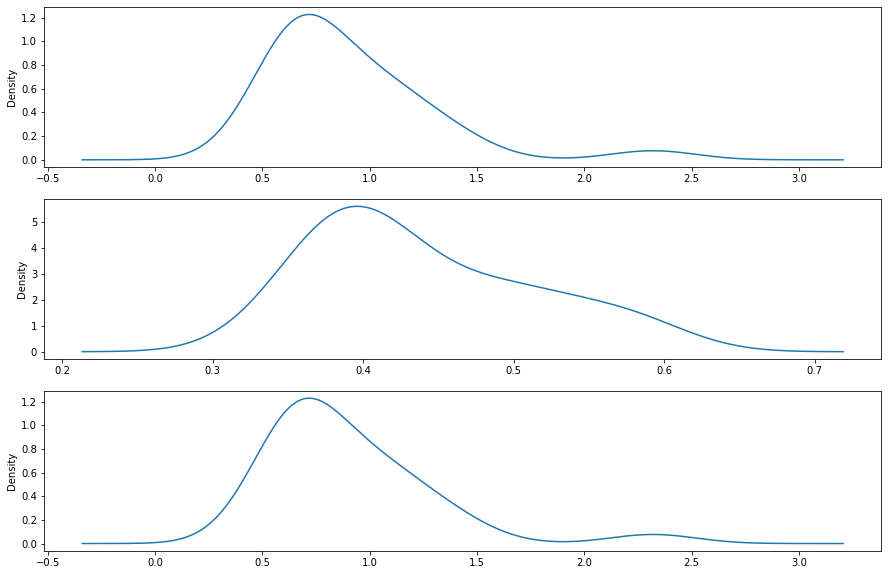

In [7]:
fig, axs = plt.subplots(3, 1, figsize = (15,10))
cv_scores_RMSE_standard["Moyenne"].plot.density(ax = axs[0])
cv_scores_MAE_standard["Moyenne"].plot.density(ax = axs[1])
cv_scores_RMSE_standard["Moyenne"].plot.density(ax = axs[2])

### Scores standards moyens

In [6]:
cv_moyen = pd.read_csv("../Data/Naif/CV_RMSE_standard.csv")["Moyenne"]
cv_moyen.mean()

0.9055013425008165

In [7]:
cv_moyen = pd.read_csv("../Data/Naif/CV_MAE_standard.csv")["Moyenne"]
cv_moyen.mean()

0.43987499938371255

In [8]:
cv_moyen = pd.read_csv("../Data/Naif/CV_R2_standard.csv")["Moyenne"]
cv_moyen.mean()

0.9897891422759089

# Score sur l'ensemble de test

In [14]:
liste_dates = mesures_test_Y["Date"]
mesures_train_X_mean = mesures_train_X[liste_stations].mean()
mesures_train_X_std = mesures_train_X[liste_stations].std()
predictions_test_Y = fct_Modele_Naif(mesures_test_X, liste_dates, liste_stations)

scores_RMSE = fct_RMSE(mesures_test_Y, predictions_test_Y, liste_stations)
scores_MAE = fct_MAE(mesures_test_Y, predictions_test_Y, liste_stations)
scores_R2 = fct_R2(mesures_test_Y, predictions_test_Y, liste_stations)

test_scores = pd.DataFrame({"Code station": liste_stations,
                            "RMSE": scores_RMSE["RMSE"],
                            "MAE": scores_MAE["MAE"],
                            "R2": scores_R2["R2"]})
test_scores.to_csv("../Data/Naif/Test_scores.csv",
                   index=False)

In [15]:
predictions_test_Y_standard = fct_Standardize(predictions_test_Y,
                                             mesures_train_X_mean, mesures_train_X_std,
                                             liste_stations)
predictions_test_Y_standard["Date"] = predictions_test_Y["Date"]
mesures_test_Y_standard = fct_Standardize(mesures_test_Y,
                                             mesures_train_X_mean, mesures_train_X_std,
                                             liste_stations)
mesures_test_Y_standard["Date"] = mesures_test_Y["Date"]

In [18]:
scores_RMSE = fct_RMSE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations)
scores_MAE = fct_MAE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations)
scores_R2 = fct_R2(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations)

test_scores_standard = pd.DataFrame({"Code station": liste_stations,
                            "RMSE": scores_RMSE["RMSE"],
                            "MAE": scores_MAE["MAE"],
                            "R2": scores_R2["R2"]})
test_scores_standard.to_csv("../Data/Naif/Test_scores_standard.csv",
                   index=False)

In [20]:
test_scores_standard[["RMSE", "MAE", "R2"]].mean()

RMSE    0.705497
MAE     0.317238
R2      0.990315
dtype: float64

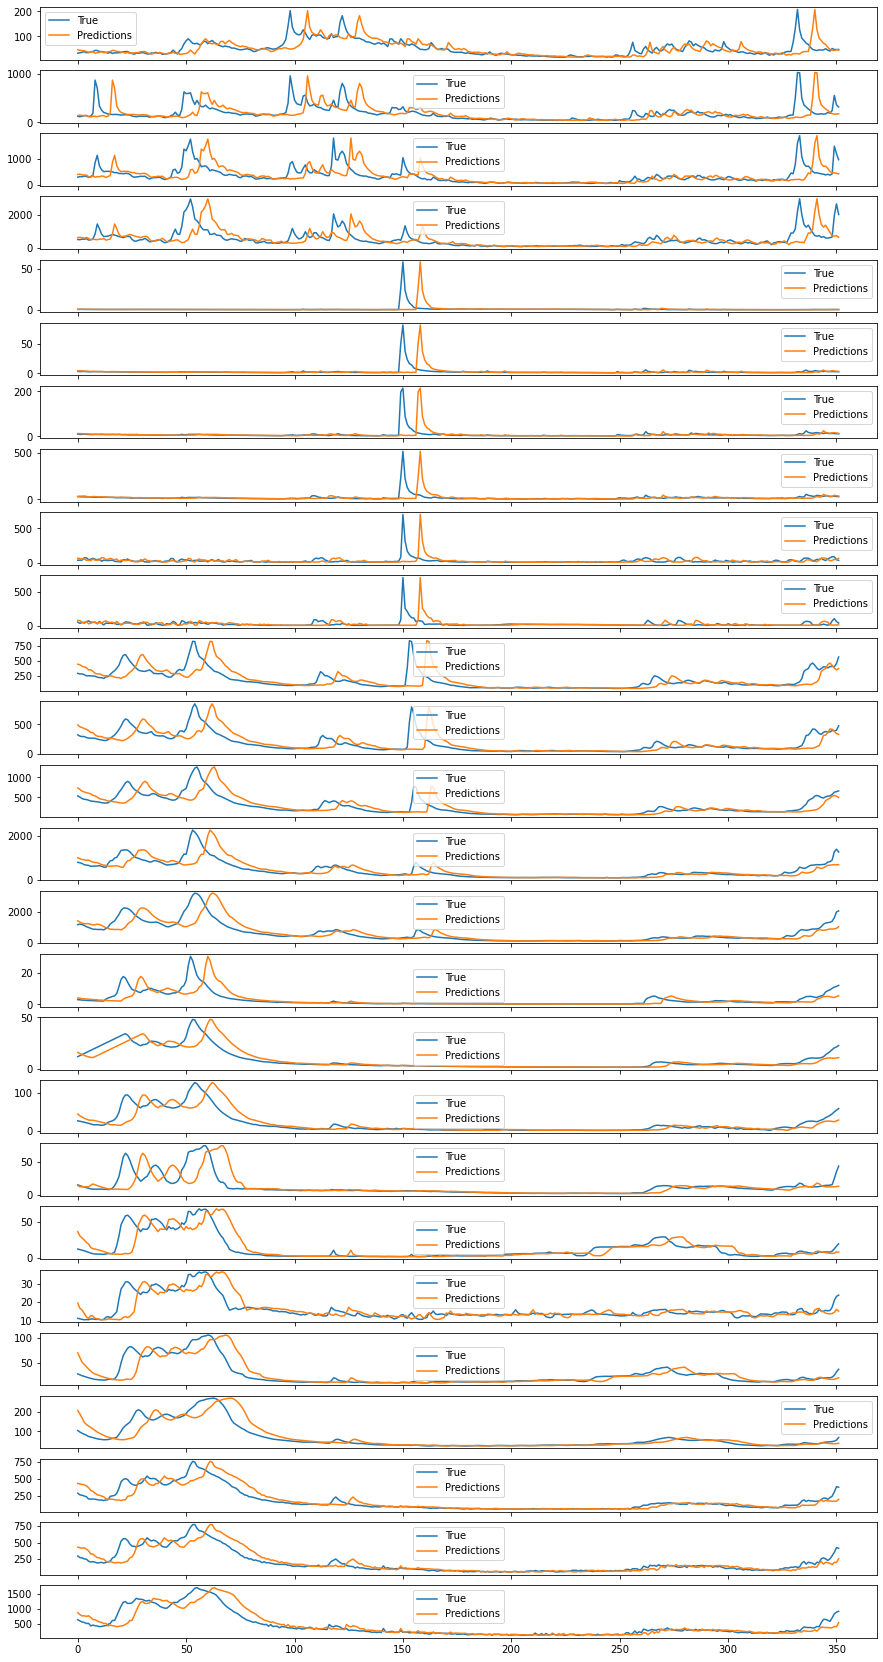

In [21]:
n_stations = len(liste_stations)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations[i]
    axs[i].plot(mesures_test_Y[code], label = "True")
    axs[i].plot(predictions_test_Y[code], label = "Predictions")
    axs[i].legend()
plt.savefig("../Data/Rapport/Figures/J7/J7_Pred.png")